In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pandas import DataFrame, merge
%pylab inline
np.random.seed(127)

Populating the interactive namespace from numpy and matplotlib


In [2]:
sns.set_palette("hls", 5)

In [3]:
animals = pd.read_csv("train.csv.gz", compression='gzip')
# animals.head()

### How OutcomeType affected by AnimalType and SexuponOutcome
Our target column is "OutcomeType". First we are interested to see how the "AnimalType" and "SexuponOutcome" attributes affect an animals outcome.

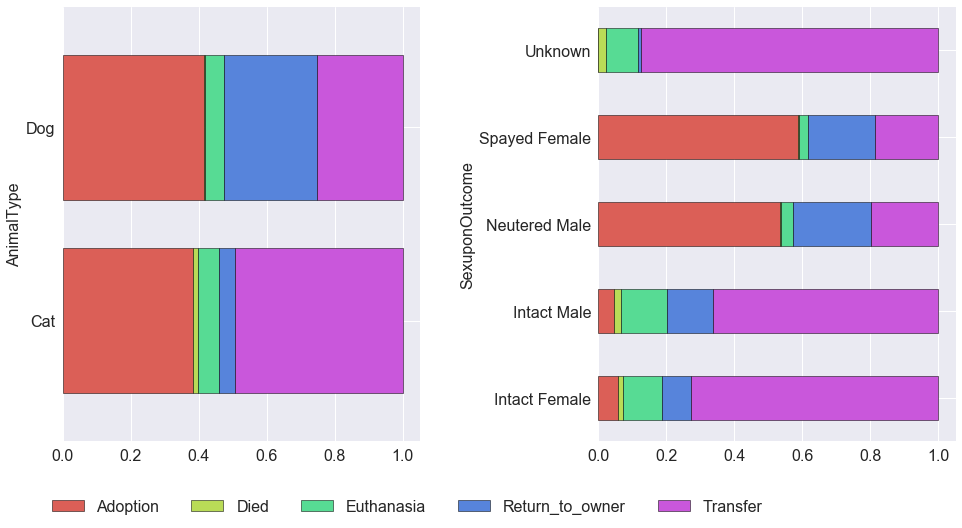

In [4]:
f, axs = plt.subplots(ncols=2)

axs[0].yaxis.label.set_size(16)
axs[1].yaxis.label.set_size(16)

f.set_size_inches(16, 8)
plt.subplots_adjust(wspace=.5)

(animals
 .groupby("AnimalType")
 .OutcomeType
 .value_counts(normalize=True)
 .unstack()
 .plot(kind="barh", stacked=True, ax=axs[0], width = 0.75, 
       fontsize=16, edgecolor='k', linewidth=0.5)
 .legend(fontsize=16, ncol=5, bbox_to_anchor=(2, -.1))
)

(animals
 .groupby("SexuponOutcome")
 .OutcomeType
 .value_counts(normalize=True)
 .unstack()
 .plot(kind="barh", stacked=True, ax=axs[1], fontsize=16, 
       edgecolor='k', linewidth=0.5, legend=False)
);

We have several findings here:
* Both dogs and cats has a low "Euthanasia" and "Died" rate, good news.
* Dogs are significantly more likely to be "Return_to_owner" than cats.
* Dogs are more likely to be in "returned_to_owner" than cats but cats has a higher "Transfer" rate
* Intact + unknown animals are more likely to be transfered. If we want to increase adoption rate, we should get animals neutered.
* This "unknown" group never gets adopted.

So far we don't know what other information we can draw from these features, we'll leave them as is.

In [5]:
# categorical feature "type"
typedict = {"Dog": 0, "Cat":1}
animals["type"] = animals["AnimalType"].map(typedict)

## Explore NULL values

In [6]:
for att in animals.columns:
    nums = animals[att].isnull().value_counts().as_matrix()
    if (len(nums) != 1):
        print "Feature \"{}\" has {} missing values".format(att, nums[-1])

Feature "Name" has 7691 missing values
Feature "OutcomeSubtype" has 13117 missing values
Feature "SexuponOutcome" has 1 missing values
Feature "AgeuponOutcome" has 18 missing values


First, we want to know the columns that has `np.nan` values and the number of `np.nan`s

### Name NULL values

Name might not seem like the first feature that matters when it comes to the outcome of an animal.However, having a name or not might affect the outcome of an animal, let's try it out.

In [7]:
# one interesting finding is that all animals that are named 'X' are transfered. We reason this might be the 
# another internal way of addressing an animal when transferring it without knowing its name. But it could also 
# be a second way they record if an animal has no name.
print "When Name is X, outcome of this animal is {}".format(animals[animals.Name == 'X'].OutcomeType.unique())

When Name is X, outcome of this animal is ['Transfer']


In [8]:
# we map nan and 'X' as '0' meaning no name, everything else has name
animals['HasName'] = animals.Name.map(lambda x : 0 if x == 'X' else 1, na_action='ignore')
animals['HasName'].fillna(value=0, inplace=True)

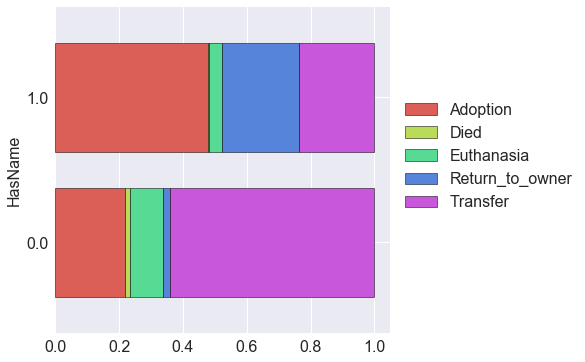

In [9]:
(animals
 .groupby("HasName")
 .OutcomeType
 .value_counts(normalize=True)
 .unstack()
 .plot(kind="barh", stacked=True, figsize=(6,6), width = 0.75, 
       fontsize=16, edgecolor='k', linewidth=0.5)
 .legend(fontsize=16, ncol=1, bbox_to_anchor=(1, 0.75))
)
ax = plt.gca()
ax.yaxis.label.set_size(16)

### DateTime Features
We would like to add additional features indicating timeofday, weekofyear, etc for each DateTime value

In [10]:
# we already know that "DateTime" column does not have null values
animals['Timestamps'] = pd.to_datetime(animals['DateTime'])

print "Our records are between the range {} to {}".format(animals.Timestamps.min(), animals.Timestamps.max())

Our records are between the range 2013-10-01 09:31:00 to 2016-02-21 19:17:00


In [11]:
# we convert timestamps to several potential groups
animals['Year'] = animals.Timestamps.dt.year
animals['Month'] = animals.Timestamps.dt.month
animals['Weekday'] = animals.Timestamps.dt.weekday
animals['Hour'] = animals.Timestamps.dt.hour
animals['WeekofYear'] = animals.Timestamps.dt.weekofyear
animals['DayofMonth'] = animals.Timestamps.dt.day

In [12]:
def plot_feature(feature, filter_=None, legend_offset=-0.3, width_inches=16.5, 
                 tick_font_size=14, label_font_size=14, title=None):
    f, axs = plt.subplots(ncols=2)
    f.set_size_inches(width_inches, 5)
    axs[0].xaxis.label.set_size(label_font_size)
    axs[1].xaxis.label.set_size(label_font_size)
    if title:
        axs[0].set_title(title, fontsize=label_font_size)
        axs[1].set_title(title, fontsize=label_font_size)
    
    
    if type(filter_) != pd.Series:
        filter_ = full(len(animals), True, dtype=bool)
    
    (animals[filter_]
     .groupby(feature)
     .OutcomeType
     .value_counts(normalize=True)
     .unstack()
     .plot(fontsize=tick_font_size,kind="bar", stacked=True, ax=axs[0], 
           edgecolor='k', linewidth=0.5, width=1, legend=False))
    
    (animals[filter_]
     .groupby(feature)
     .OutcomeType.value_counts()
     .unstack()
     .plot(fontsize=tick_font_size, kind="bar", stacked=True, ax=axs[1], 
           edgecolor='k', linewidth=0.5, width=1)
     .legend(fontsize=label_font_size, ncol=5, 
             bbox_to_anchor=(-.1, legend_offset), loc='center'))

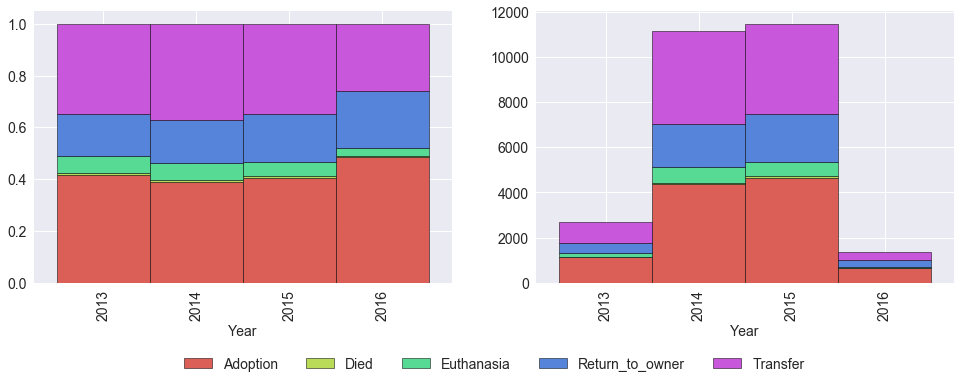

In [13]:
plot_feature("Year")

Year does not seem to be an important feature as percentage-wise it does not affect animal outcome very much with the exception of 2016. However, since we have a lot less samples in 2016, the percentage advantage of later year is hard to infer.

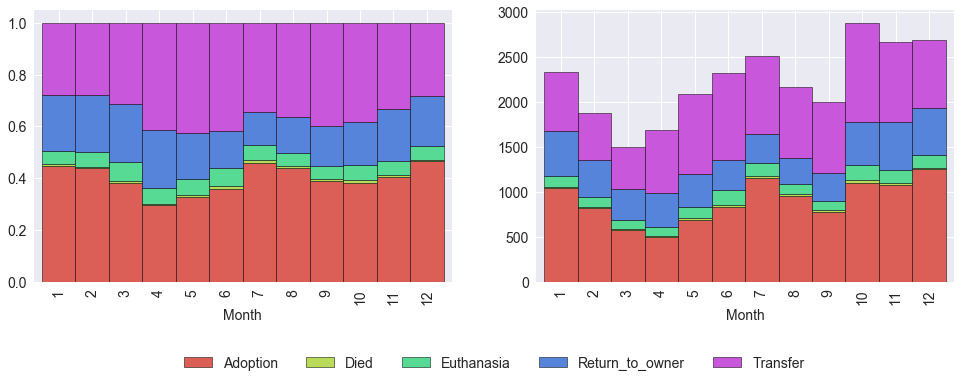

In [14]:
plot_feature("Month")

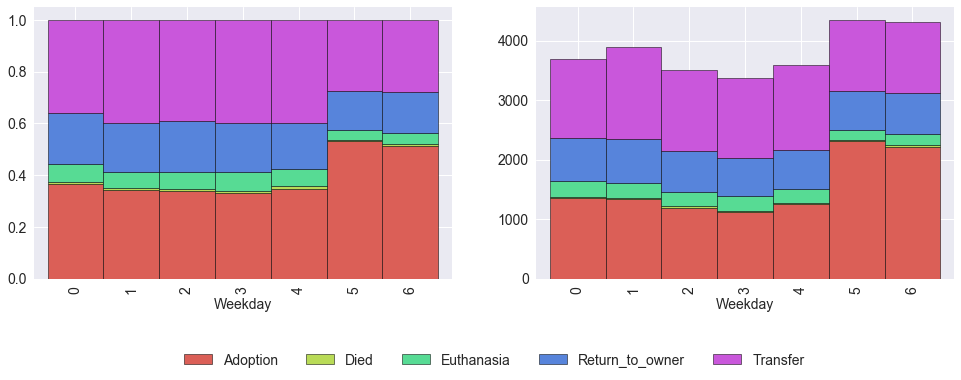

In [15]:
plot_feature("Weekday")

Fridays and Saterdays have a higher adoption rate but lower than average transfer rate. 

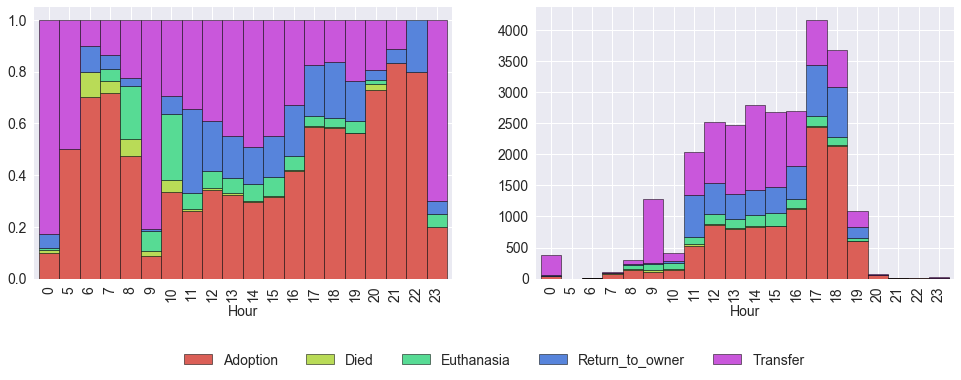

In [16]:
plot_feature("Hour")

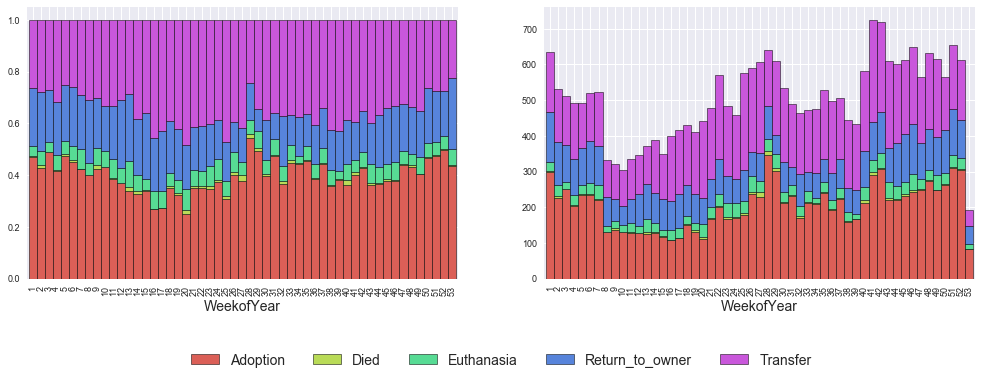

In [17]:
plot_feature("WeekofYear", width_inches=17, tick_font_size=9)

In [18]:
import holidays

from dateutil.relativedelta import relativedelta
from datetime import date
class MyHolidays(holidays.UnitedStates):
    def _populate(self, year):
        # Populate the holiday list with the default US holidays
        holidays.UnitedStates._populate(self, year)
        # Remove Columbus Day
        # self.pop(date(year, 10, 1) + relativedelta(weekday=MO(+2)), None)
        # Add Valentines Day
        self[date(year, 2, 14)] = "Valentines Day"
        self[date(year, 1, 1) + relativedelta(weekday=MO(+3))] = "Martin Luther King Day"
        self[date(year, 2, 1) + relativedelta(weekday=MO(+3))] = "President's Day"
        self[date(year, 5, 1) + relativedelta(weekday=SU(+2))] = "Mother's Day"
        self[date(year, 6, 1) + relativedelta(weekday=SU(+3))] = "Father's Day"
        self[date(year, 10, 31)] = "Halloween"

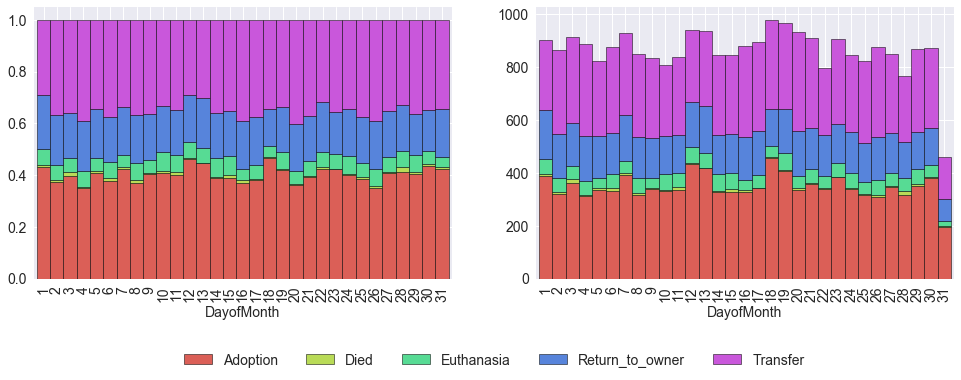

In [19]:
plot_feature('DayofMonth')


In [20]:
def is_holiday(t):
    tx_holidays = MyHolidays(state="TX", years =[2015])
    dt = datetime.datetime.strptime(t, r"%Y-%m-%d %H:%M:%S")
    if (dt.month in [1,12,7,8]) or (dt.date() in tx_holidays) or dt.weekday() in [5,6]:
        return True
    return False

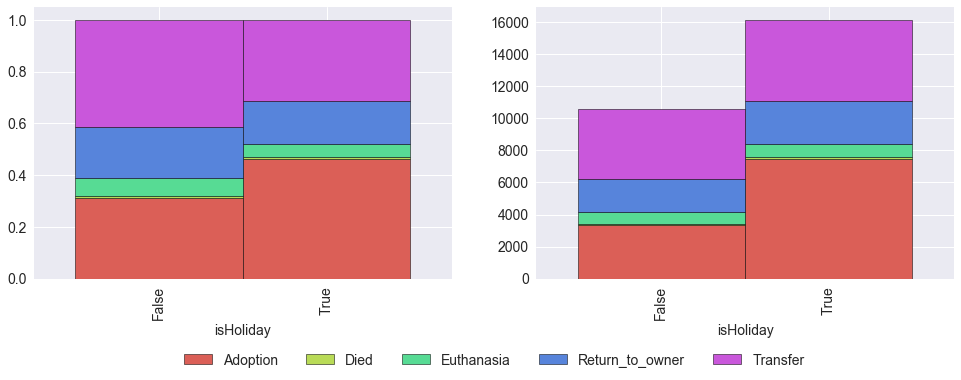

In [21]:
animals["isHoliday"] = animals["DateTime"].apply(is_holiday)
plot_feature("isHoliday")

### AgeuponOutcome 
First we need to use the same unit on AgeuponOutcome feature. We decide to convert all of them into days. Note that some animals has an age of "0 years"

The interesting finding is that all animals are missing age info happened in a very small time window.

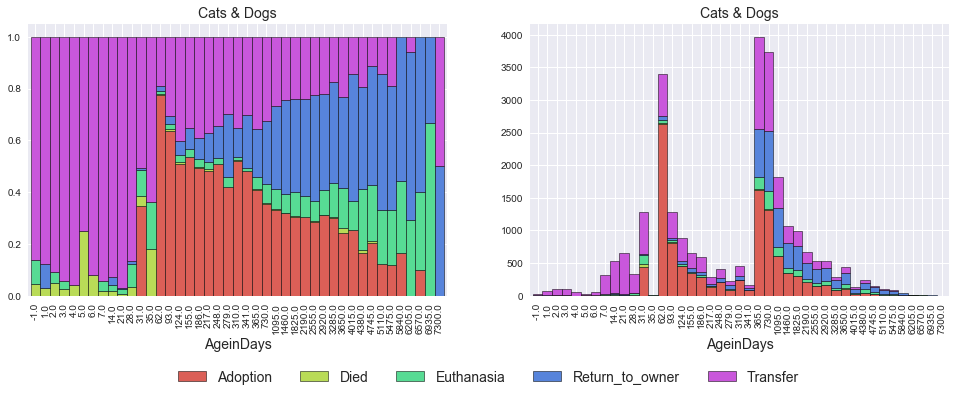

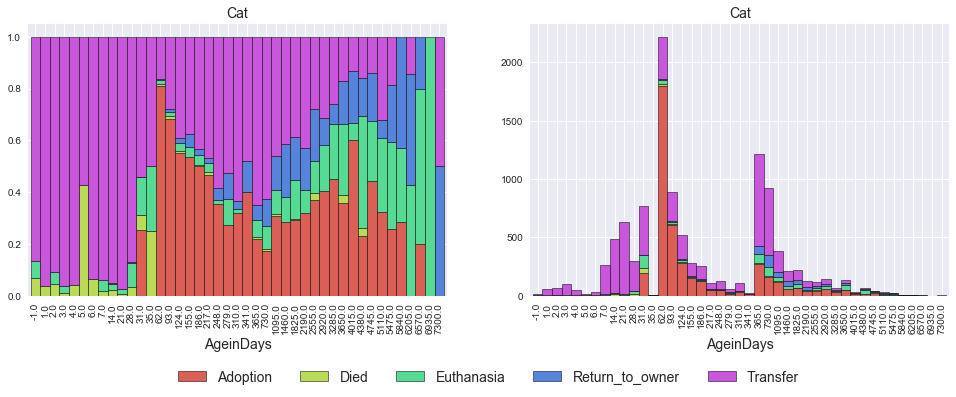

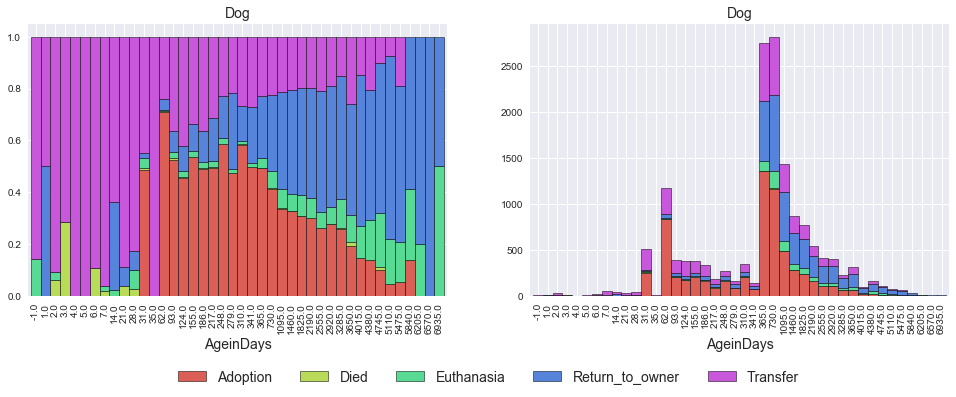

In [22]:
units = {"year" : 365, "month":31, "day":1, "week":7}

def get_age_in_days(agestring):
    tokens = agestring.split(" ")
    unit = tokens[1].replace("s","")
    days = int(tokens[0]) * units[unit]
    # return days
    return days if days != 0 else -1

animals["AgeinDays"] = animals.AgeuponOutcome.map(get_age_in_days, na_action="ignore")

plot_feature('AgeinDays', tick_font_size=10, title='Cats & Dogs')
plot_feature('AgeinDays', animals.AnimalType=='Cat', tick_font_size=10, title='Cat')
plot_feature('AgeinDays', animals.AnimalType=='Dog', tick_font_size=10, title='Dog')

/Users/mattspinnelli/anaconda3/envs/ser627a/lib/python2.7/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools
/Users/mattspinnelli/anaconda3/envs/ser627a/lib/python2.7/site-packages/numpy/lib/arraysetops.py:216: FutureWarning: numpy not_equal will not check object identity in the future. The comparison did not return the same result as suggested by the identity (`is`)) and will change.
  flag = np.concatenate(([True], aux[1:] != aux[:-1]))


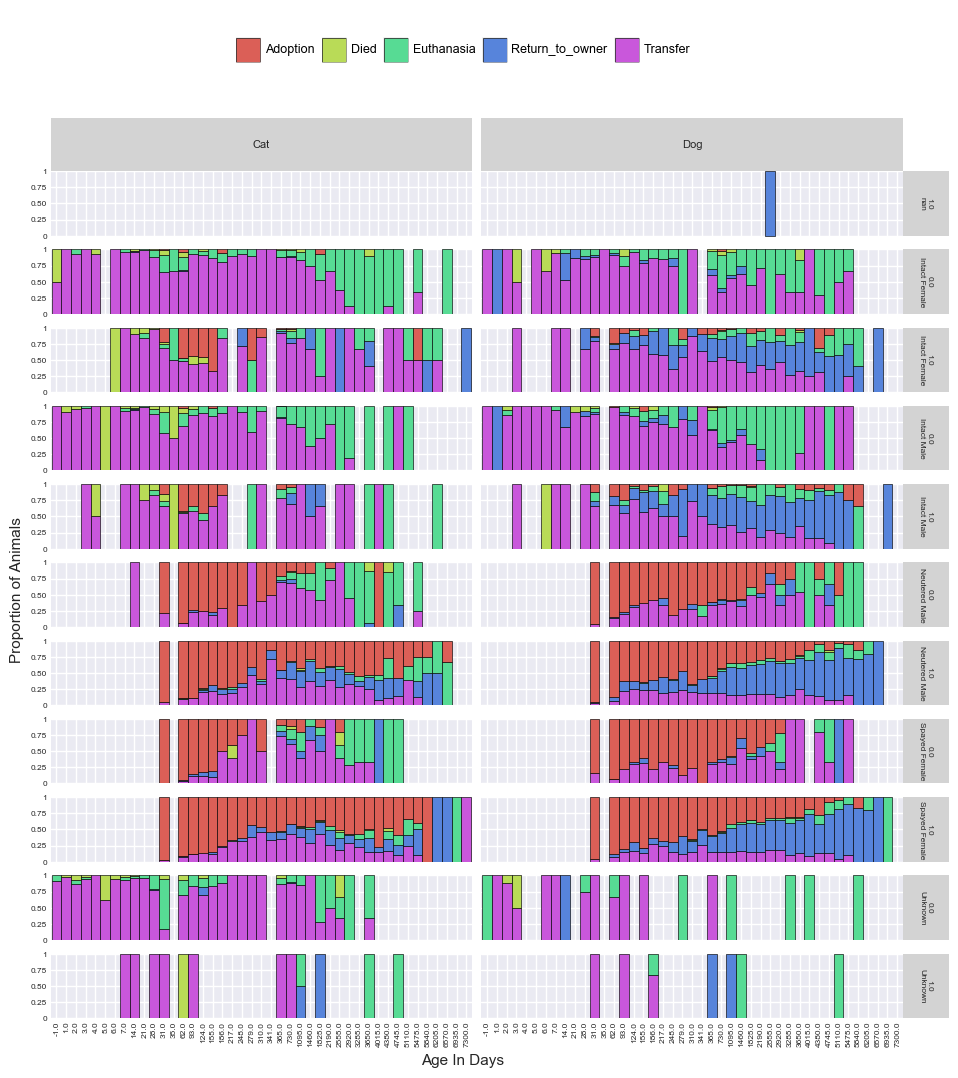

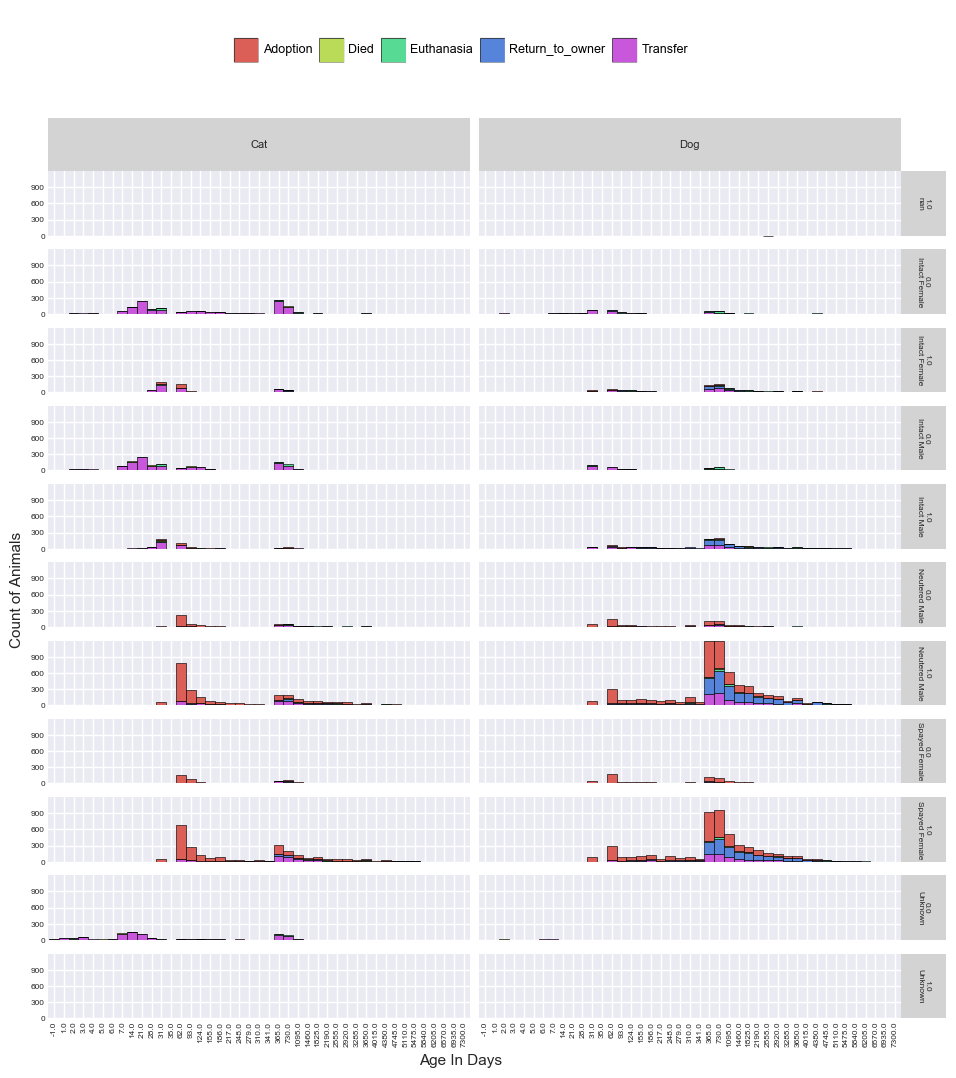

In [23]:
from plotnine import *
animals['AgeInDaysCategorical'] = pd.Categorical(animals.AgeinDays)
for position, label in [('fill', 'Proportion'), ('stack', 'Count')]:
    p = (ggplot(animals[animals.AgeinDays.notnull()], 
                aes(x = 'AgeInDaysCategorical', fill = 'OutcomeType'))
     + geom_bar(position = position, width=1, color='black', size=0.25)     
     + facet_grid('SexuponOutcome + HasName ~ AnimalType')
     + labs(x = 'Age In Days', y = '{} of Animals'.format(label))
     + coord_cartesian(ylim=[0, 1])
     + theme_seaborn()
     + theme(axis_text_x = element_text(angle = 90, size = 6),
             axis_text_y = element_text(size = 6),
             panel_grid_minor = element_blank(),
             legend_position = 'top',
             panel_spacing = 0.05,
             legend_title = element_blank(),
             legend_text=element_text(size=9),
             strip_text_x = element_text(size = 8),
             strip_text_y = element_text(size = 6))
    )    
    if position == 'dodge':
        p += scale_y_sqrt(breaks=(10, 200, 1000, 2000), expand = [0,0])
    else:
        p += scale_y_continuous(expand = [0,0])
    p.draw().set_size_inches(11,11)
animals.drop(['AgeInDaysCategorical'], axis=1);

In [24]:
print "{} to {}".format(animals[animals.AgeinDays.isnull()].Timestamps.min(), 
                        animals[animals.AgeinDays.isnull()].Timestamps.max())

2016-02-09 19:43:00 to 2016-02-21 18:22:00


In [25]:
# if we comebine them with all the AgeinDays == 0 animals, the outcome looks like this: No one was adopted
animals[animals.AgeinDays.isnull() | animals.AgeinDays==0].OutcomeType.value_counts()
# So we decide to group nan and 0 year animals to -1

Series([], Name: OutcomeType, dtype: int64)

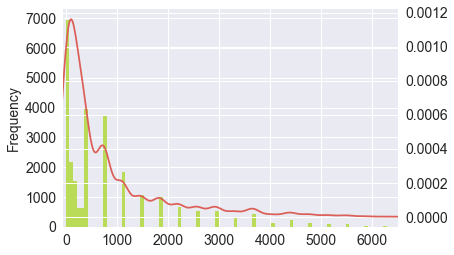

In [26]:
# Now the distribution of ageindays looks like:
fig, ax = plt.subplots()
animals["AgeinDays"].plot(fontsize=14, kind="kde", ax=ax, xlim=(-50, 6500), secondary_y=True)
animals["AgeinDays"].plot(fontsize=14, kind="hist", bins=100, xlim=(-50, 6500),  ax=ax, zorder=2)
twin_ax = ax.figure.axes[1]
ax.yaxis.label.set_size(14)
[tick.set_fontsize(14) for tick in twin_ax.yaxis.get_ticklabels()];

We have more young animals than old. The probability distribution is greately affected by the records (very discrete). We decide to also map ages to infant, child, young adult, adult and old groups

In [27]:
bins = [-5, 0, 5 * units["month"], 12 * units["month"], 3*units["year"],
        6 * units["year"], 10*units["year"], 20 * units["year"]]
labels = ["Unknown", "Infant", "Puppy/Kitten", "Young Adult", "Adult", "Senior", "Geriatric"]

animals["LifeStage"] = pd.Categorical(pd.cut(animals.AgeinDays, bins=bins, labels=labels), categories=labels)

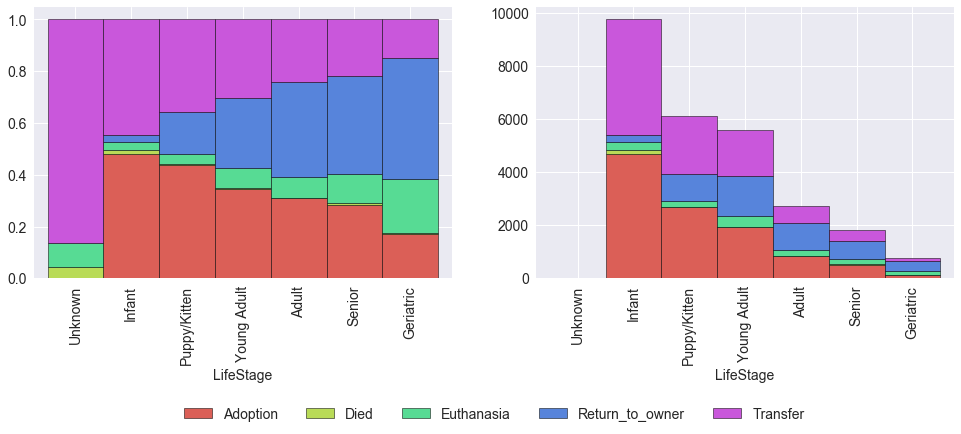

In [28]:
plot_feature('LifeStage', legend_offset=-.5)

### SexuponOutcome NULL and Unknown values

In [29]:
animals[animals.SexuponOutcome.isnull()]

,AnimalID,Name,DateTime,OutcomeType,OutcomeSubtype,AnimalType,SexuponOutcome,AgeuponOutcome,Breed,Color,...,Year,Month,Weekday,Hour,WeekofYear,DayofMonth,isHoliday,AgeinDays,AgeInDaysCategorical,LifeStage
3174,A667395,Diego,2013-11-27 16:11:00,Return_to_owner,NaN,Dog,NaN,7 years,Dachshund,Brown Merle,...,2013,11,2,16,48,27,False,2555.0,2555.0,Senior


In [30]:
animals[(animals.SexuponOutcome.str.contains("Male")) & 
        (animals.AgeuponOutcome=="7 years")&
        (animals.AnimalType=="Dog") &
        (animals.OutcomeType=="Return_to_owner")
       ].SexuponOutcome.value_counts()

Neutered Male    97
Intact Male      13
Name: SexuponOutcome, dtype: int64

In [31]:
# Given its name other info, I guess it is a male, so we narrowed down to all similar animals and 
# assign the majority sex to it.
animals.loc[3174, "SexuponOutcome"] = "Neutered Male"

As was shown before, "Unknown" sex has a disticntive distribution of outcome compared with other sex, we decide to
leave it as is. Or, we could try [different encoding schemes](http://contrib.scikit-learn.org/categorical-encoding/) and see which one works the best on our project.

So I'm planning to impute all these randomly with the top two sex within age range (0 days - 2 month) Or I should scale it idk.

In [32]:
unknowns = animals[animals.SexuponOutcome == "Unknown"]

# so we try to see what their most shared features here
print "AnimalType Mode: ", unknowns.AnimalType.agg('mode')[0]
print "AgeinDays Median: ", unknowns.AgeinDays.median()
print "OutcomeType Mode:", unknowns.OutcomeType.mode()[0]
print "HasName Mode", unknowns.HasName.mode()[0]

AnimalType Mode:  Cat
AgeinDays Median:  21.0
OutcomeType Mode: Transfer
HasName Mode 0.0


These animals are mostly cats, 21 days old, no name and ended up being transfered. We pull out all records that fits this criteria:

In [33]:
print "Total number of: ", len(unknowns)
p = animals[(animals.AnimalType=="Cat") & 
        (animals.AgeinDays<= 31) & 
        (animals.OutcomeType=="Transfer") &
        (animals.HasName==0) & 
        (animals.SexuponOutcome!="Unknown" )].SexuponOutcome.value_counts(normalize=True)
print p

Total number of:  1093
Intact Male      0.533679
Intact Female    0.463360
Neutered Male    0.002961
Name: SexuponOutcome, dtype: float64


So they are 53 percent intact male and 46 percent intact female. We either can use bernoulli/multinomial (if we really care) when assigning sex on these animals or leave as is.

In [34]:
from scipy.stats import bernoulli
im_p = p["Intact Male"] 

In [35]:
def unknown_sex(sexstring):
    if sexstring == "Unknown":
        sex = bernoulli.rvs(im_p)
        if sex == 1:
            return "Intact Male"
        else:
            return "Intact Female"
    else:
        return sexstring

In [36]:
animals["BernoulliSex"] = animals["SexuponOutcome"].map(unknown_sex, na_action="ignore")

animals.loc[animals.SexuponOutcome=="Unknown", "BernoulliSex"].value_counts(normalize=True)

Intact Male      0.542543
Intact Female    0.457457
Name: BernoulliSex, dtype: float64

While we are imputing ourselves and scikit-learn has the most basic imputer, we can also try [Orange](https://docs.orange.biolab.si/2/reference/rst/Orange.feature.imputation.html) as well.

### Getting Breed information

We need more information about "Breed". So we got some information from online sources.
We think dog size and their characteristics are key features when people look for dogs. However, considering lots of shelter animals were abused, their characteristic may change. Not sure if dog personalities would be important in this case, but we are keeping it for now.

In [37]:
# Currently this website is now giving 404 error, fortunetly we saved the
# the data inot a CSV file

# import urllib2
# from bs4 import BeautifulSoup

# url = "http://www.sorteaze.com/dog-breed-personality--social-traits.html"
# page = urllib2.urlopen(url).read()
# soup = BeautifulSoup(page, "lxml")

# data = []
# for tr in soup.find_all('tr')[4:218]:
#     tds = tr.find_all('td')
#     data.append([td.text.encode('utf-8').strip() for td in tds])

# columns = [th.text.encode('utf-8').strip() for th in soup.find_all('th')]
# dog_personality = pd.DataFrame(data, columns=columns)

In [38]:
# Currently this website is now giving 404 error, fortunetly we saved the
# the data inot a CSV file

# url = "http://www.sorteaze.com/dog-breeds.html"
# page = urllib2.urlopen(url).read()
# soup = BeautifulSoup(page, "lxml")

# data = []
# for tr in soup.find_all('tr')[3:217]:
#     tds = tr.find_all('td')
#     data.append([td.text.encode('utf-8').strip() for td in tds])
    
# columns = [th.text.encode('utf-8').strip() for th in soup.find_all('th')]

# dog_traits = pd.DataFrame(data, columns=columns)

In [39]:
# Currently this website is now giving 404 error, fortunetly we saved the
# the data inot a CSV file
# dog_data = pd.merge(dog_personality, dog_traits, on='Breed Name', how='outer')

dog_data = pd.read_csv('dog_data.csv').iloc[:, 1:]
dog_data.head()

,Breed Name,Protects Property,Hunts & Chases,Less Likely to Wander,Loving,Child-Friendly,Dog-Friendly,Pet-Friendly,Stranger-Friendly,Avg Height (inches),Avg Weight (pounds),Size Score (1 to 5),Avg Age,Fewer Health Issues,Energetic,Intelligent,Easy to Train
0,Affenpinscher,4,2,5,5,2,3,4,4,10,10,1,11,3,3,4,3
1,Afghan Hound,2,5,1,2,3,3,3,3,26,55,4,12,3,4,3,2
2,Airedale Terrier,4,3,3,4,4,2,2,3,22,53,3,12,4,5,4,4
3,Akita,5,3,4,5,1,1,1,2,27,105,5,11,4,4,3,2
4,Alaskan Klee Kai,3,3,2,4,4,4,2,2,15,15,2,14,4,4,4,3


In [40]:
# this uses data from the websites, which aren't available 

# dog_data.rename(columns=lambda x : x.replace(" ", ""), inplace=True)
# dog_data.loc[:, "BreedName"] = dog_data.BreedName.str.replace("- ", "")

# dog_data.drop(dog_data.columns[range(1,4)+ [9,14,15]], inplace=True,axis=1)
# dog_data["Friendliness"] = dog_data.iloc[:, 1:6].as_matrix().astype(int).mean(1)
# dog_data.drop(dog_data.columns[range(1,6)+[7,10]], inplace=True,axis=1)

# dict={"Herding":"Working", "Fighting":"Guarding", "Terrier":"Companion"}
# dog_data.loc[:, "Bredfor"] = dog_data.Bredfor.map(lambda s: dict[s] if dict.has_key(s) else s, na_action="Ignore")

# dog_data.loc[:, "Intelligent"] = dog_data.iloc[:, 4:6].as_matrix().astype(int).mean(1)
# dog_data.drop(["EasytoTrain"], axis=1, inplace=True)
# dog_data.BreedName.str.replace("-", " ").str.split(" ")

In [41]:
dog_data.rename(columns=lambda x : x.replace(" ", ""), inplace=True)
dog_data.loc[:, "BreedName"] = dog_data.BreedName.str.replace("- ", "")

dog_data.drop(dog_data.columns[range(1,4)+ [13,14]], inplace=True,axis=1)

dog_data["Friendliness"] = dog_data.iloc[:, 1:5].as_matrix().astype(int).mean(1)
dog_data.drop(dog_data.columns[range(1,6)], inplace=True,axis=1)

dog_data.head()

dog_data.loc[:, "Intelligent"] = dog_data.iloc[:, 5:6].as_matrix().astype(int).mean(1)
dog_data.drop(["EasytoTrain"], axis=1, inplace=True)

In [42]:
import re
import itertools
from functools import wraps
import sys

def memoize(func):
    cache = {}
    @wraps(func)
    def wrap(*args):
        if args not in cache:
            cache[args] = func(*args)
        return cache[args]
    return wrap

@memoize
def try_permutations(tokens):    
    min_count = sys.maxint
    best_string = None
    for i in range(len(tokens)):
        candidate = itertools.permutations(tokens, i+1)
        for c in candidate:
            string = ' '.join(x for x in c)            
            count = len(dog_data[dog_data.BreedName.str.contains(
                string, case=False)])
            if count == 1:
                return string
            if count < min_count and count != 0:
                min_count, best_string = count, string
    return best_string
            

def add_dog_data(x):
    name = x.Breed.replace(" Mix", "")
    breeds= name.split("/")
    # assert len(breeds) <= 2
    
    matches = pd.DataFrame()
    for br in breeds:
        best_string = try_permutations(frozenset(br.split(" ")))
        if best_string:
            matches = pd.concat(
                [matches, 
                 dog_data[dog_data.BreedName.str.contains(
                     best_string, case=False)]
                ])
    
    return pd.Series(matches.iloc[:,2:]
                     .as_matrix()
                     .astype(int)
                     .mean(axis=0)
                     .round(0))                

animals[dog_data.columns[2:]] = (animals[animals.AnimalType=='Dog']
                                 .apply(add_dog_data, axis=1))
# dog_data.to_csv('dog_data_clean.csv')
# animals.drop("Bredfor", axis=1, inplace=True)

/Users/mattspinnelli/anaconda3/envs/ser627a/lib/python2.7/site-packages/ipykernel_launcher.py:50: RuntimeWarning: Mean of empty slice.


In [43]:
def mix_type(x):
    if 'mix' in x.lower():
        return 'Mix'
    elif '/' in x:
        return 'Cross'
    else:
        return 'Pure'

animals['MixType'] = animals["Breed"].map(mix_type)

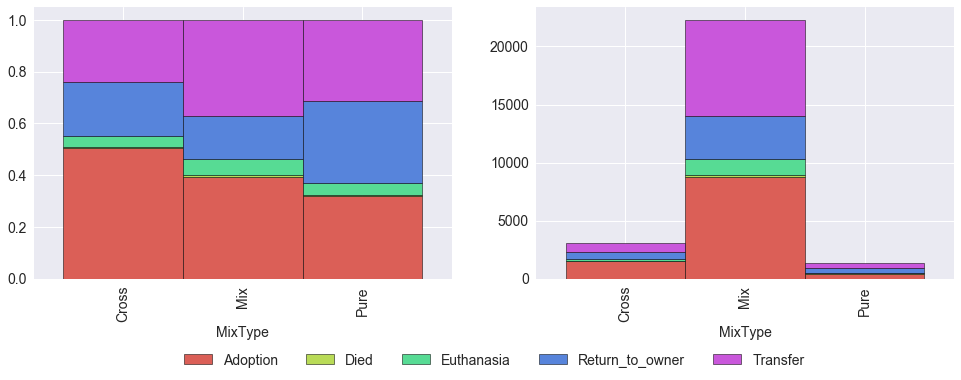

In [44]:
plot_feature('MixType')

In [45]:
animals.loc[animals.AnimalType=="Cat", 'AvgWeight(pounds)'] = 9
animals.loc[animals.AnimalType=="Cat", 'SizeScore(1to5)'] = 1
animals.loc[animals.AnimalType=="Cat", "Intelligent"] = 3
animals.loc[animals.AnimalType=="Cat", "Friendliness"] = 3

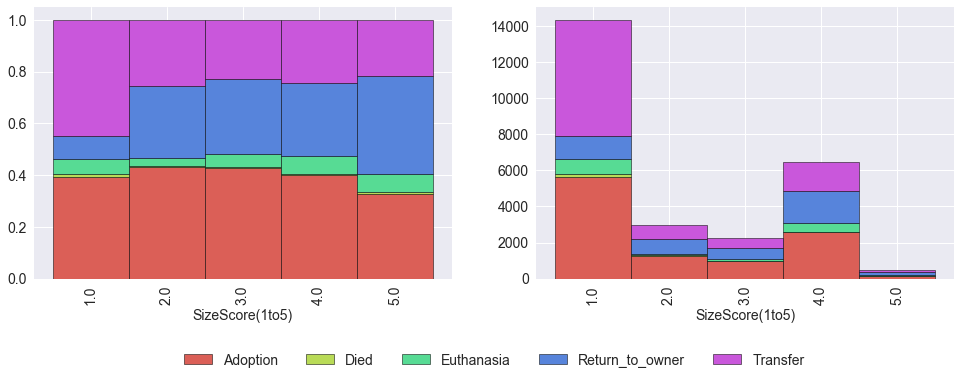

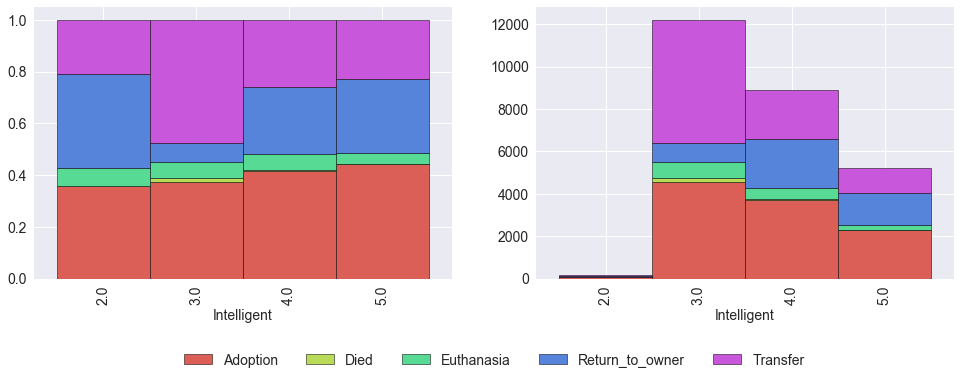

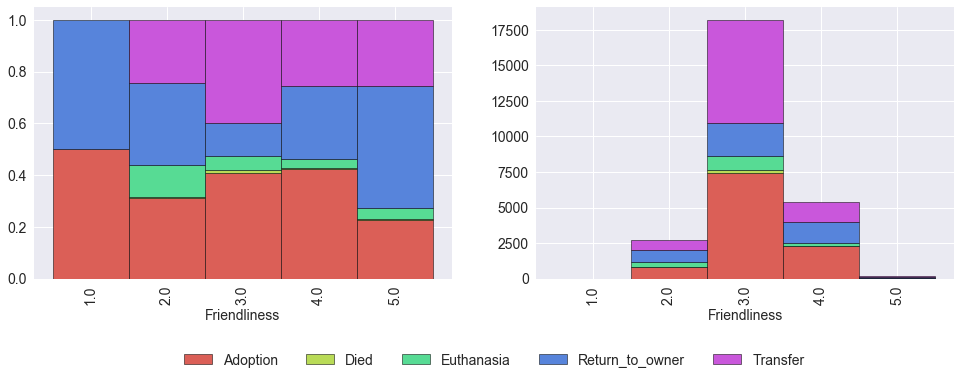

In [46]:
plot_feature('SizeScore(1to5)')
plot_feature('Intelligent')
plot_feature('Friendliness')

# Hair length and Color

So far these two are not very helpful

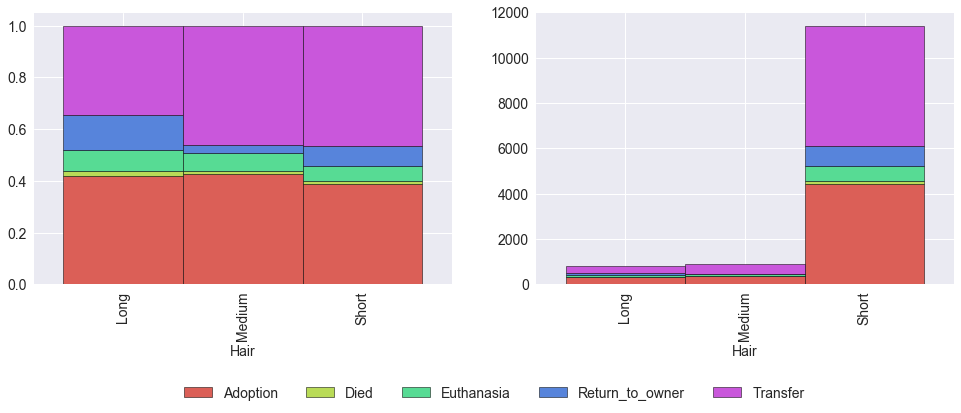

In [47]:
def hair(x):
    if 'Short' in str(x):
        return 'Short'
    elif 'Medium' in str(x):
        return 'Medium'
    elif 'Long' in str(x):
        return 'Long'
    else:
        return np.nan

animals['Hair'] = animals["Breed"].map(hair)
plot_feature('Hair', legend_offset=-.4)

A lot of the color information for cats happens to be not just color but also the pattern (this also applies to dogs in some cases and others [like Merle]). A good resource for learning about cat colors and patterns is here: http://fixnation.org/2010/07/what-color-is-that-cat/. Using that resource let's map the colors and patterns to a smaller, more managable set.

In [48]:
color_pattern = dict(
    Tabby='Tabby',
    Agouti='Tabby',
    Tiger='Tabby',
    Point='Point',
    Tortie='TriColor',
    Calico='TriColor',
    Torbie='TriColor',
    Brindle='TriColor',
    Smoke='Smoke',
    Merle='Merle')

color_synonym =dict(
    Flame='Orange',
    Apricot='Orange',
    Red='Red',
    Ruddy='Red',
    Gold='Yellow',
    Cream='Tan',
    Buff='Tan',
    Fawn='Tan',
    Liver='Brown',
    Seal='Brown',
    Sable='Brown',
    Chocolate='Brown',
    Blue='Grey',
    Lilac='Grey',
)

main_color = [
    'Black', 
    'Brown', 
    'Yellow', 
    'Gray', 
    'Orange', 
    'Pink', 
    'Red', 
    'Silver', 
    'Tan',
    'White']

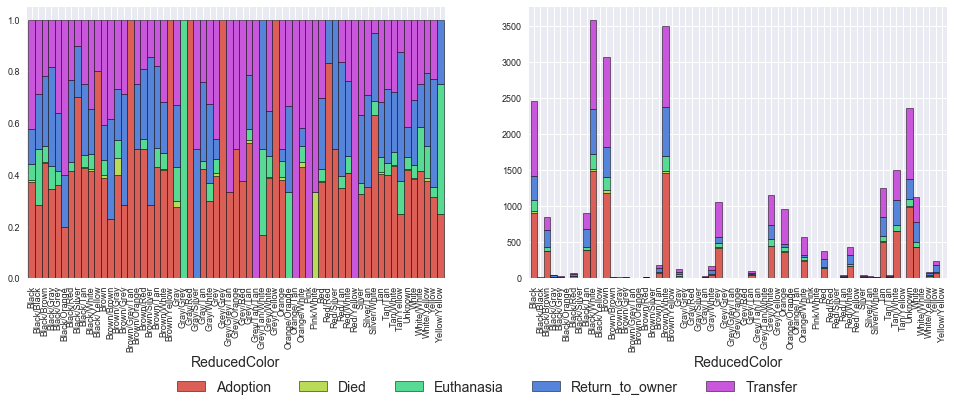

In [49]:
def reduce_colors(color):
    result = [] 
    for c in [c.strip() for c in re.split('/| ', color)]:
        if c in main_color:
            result.append(c)
        elif c in color_synonym.keys():
            result.append(color_synonym[c])
    return 'Unknown' if not result else '/'.join(sort(result))
    
animals['ReducedColor'] = animals.Color.map(reduce_colors)
plot_feature('ReducedColor', tick_font_size='9', legend_offset=-0.4)

There are 63 reduced colors above and the mix of dogs and cats might affect the proportions of outcomes so let's just show the 10 most popular for cats and then dogs.

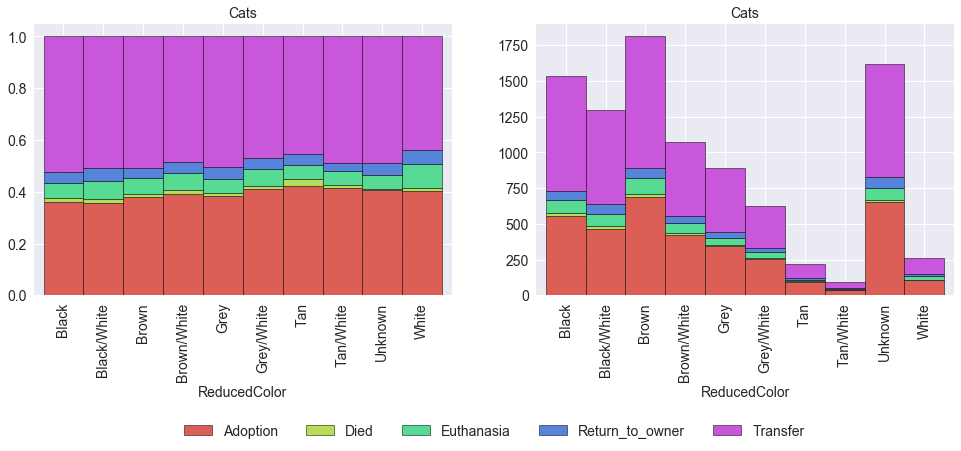

In [50]:
plot_feature('ReducedColor', 
             (animals.ReducedColor.isin(animals
                                        .ReducedColor
                                        .value_counts()
                                        .nlargest(10)
                                        .index
                                        .tolist())) & (animals.AnimalType=='Cat'), 
             legend_offset=-0.5, title='Cats') 

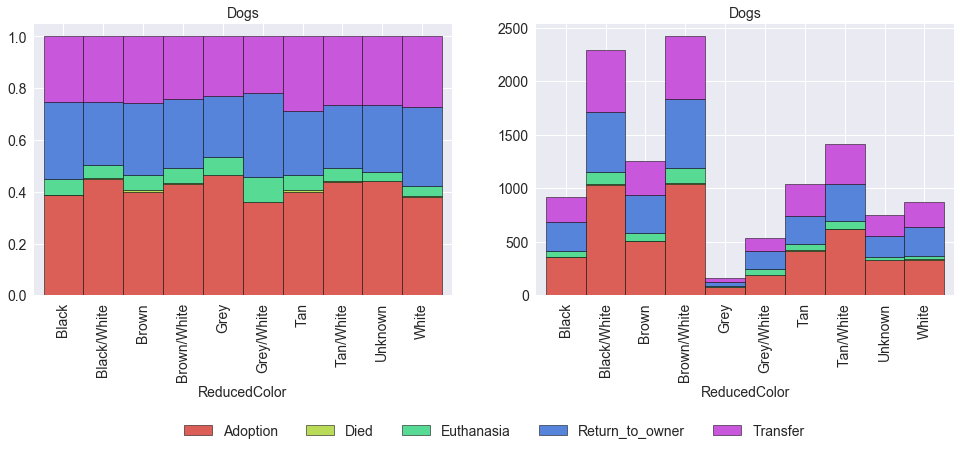

In [51]:
plot_feature('ReducedColor', 
             (animals.ReducedColor.isin(animals
                                        .ReducedColor
                                        .value_counts()
                                        .nlargest(10)
                                        .index
                                        .tolist())) & (animals.AnimalType=='Dog'), 
             legend_offset=-0.5, title='Dogs') 

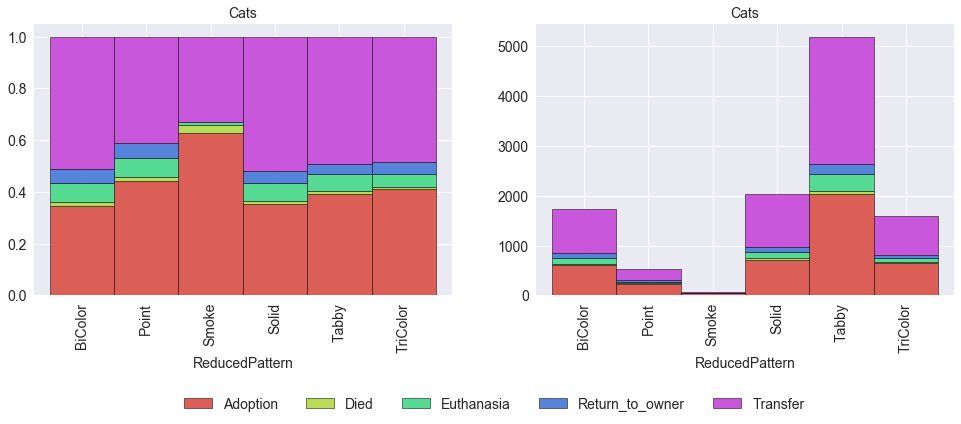

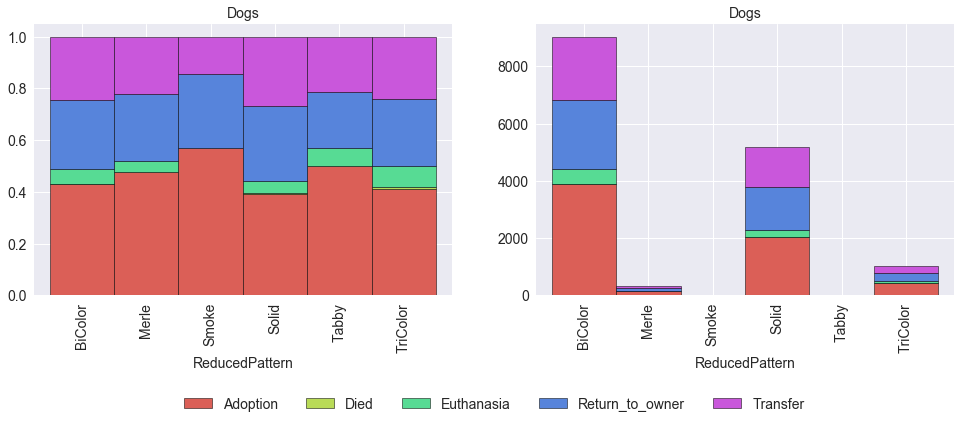

In [52]:
def reduce_pattern(color):
    result = None
    for c in [c.strip() for c in re.split('/| ', color)]:
        if c in color_pattern.keys():
            return color_pattern[c]
    return 'BiColor' if '/' in color else 'Solid'

animals['ReducedPattern'] = animals.Color.map(reduce_pattern)

plot_feature('ReducedPattern', filter_=animals.AnimalType=='Cat', 
             title='Cats', legend_offset=-0.4)

plot_feature('ReducedPattern', filter_=animals.AnimalType=='Dog', 
             title='Dogs', legend_offset=-0.4)

In [53]:
# animals.to_csv("animal")

### We might get weather too. I'm just leaving it here
[This](https://pypi.python.org/pypi/get-weather-data) looks promising.

In [54]:
import category_encoders as ce

encoder = ce.BackwardDifferenceEncoder(cols=["SexuponOutcome"])